In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def quantize(x, s):
    return int(np.clip(np.round(s*x), -128, 127))

def sigmoid(x): 
    return 1 / (1 + math.exp(-x))

# https://sci-hub.se/10.1109/ICENCO48310.2019.9027479
def zaki_sig_default(x):
    if x >= 0:
        return (math.log2((2 * x) + 0.486) / 8) + 0.63
    else:
        return (-math.log2((-x * 0.5) + 0.008458) / 16) + 0.07

def zaki_sigq(x, s):
    x = quantize(x, s)
    if x >= 0:
        return (quantize(math.log2((x << 1) + 127), s) >> 3) + quantize(0.63, 409.30)
    else:
        return -(quantize(math.log2(-(x >> 1) + 3), s) >> 4) + quantize(0.07, 409.30)

In [3]:
val = -12.121
print(sigmoid(val))
print(zaki_sig_default(val))

5.443951163233243e-06
-0.09259055228337995


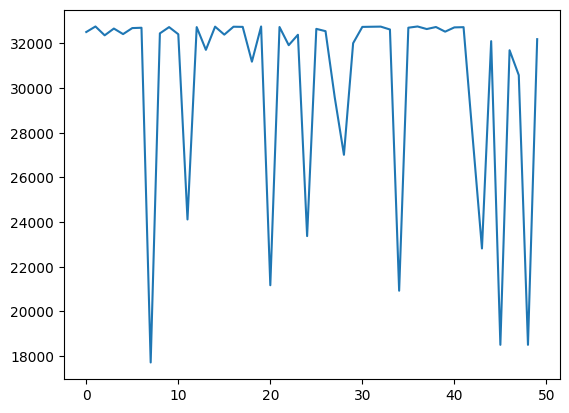

In [4]:
arr = 5 * np.random.random_sample((150,))
x = [i for i in range(-10, 11)]
ys = []
ys.append(("logistic", [32510,32758,32362,32665,32417,32686,32701,17715,32449,32730,32411,24118,32730,31712,32750,32393,32747,32740,31182,32757,21173,32734,31921,32387,23373,32651,32548,29586,27013,32010,32739,32746,32752,32623,20928,32703,32758,32643,32734,32526,32717,32727,27745,22819,32101,18505,31695,30579,18505,32190]))
#ys.append(("default",  [100 * sigmoid(i) for i in x]))
#ys.append(("zaki", [zaki_sig_default(i) for i in x]))
#ys.append(("zaki_q", [zaki_sigq(i, 409.30) for i in x]))
for (name, li) in ys:
    plt.plot(li, label=name)

In [5]:
array = [0.486, 0.00848, 0.63, 0.007]
s = 255 / (np.max(array) - np.min(array))

In [6]:
def normal_get(b, indices):
    return b[indices]

## Return strides array given shape 
def get_stride_vec(shape):
    li = []
    for i in range(len(shape)):
        product = np.prod(shape[i+1:])
        li.append(product)
    return np.array(li).astype(np.int32)

## auxillary
def get_with_stride(b, indices, strides):
    stride = np.sum(strides * indices)
    #print(f"index: {stride}")
    #print(f"value: {b.flatten()[stride]}")
    return b.flatten()[stride]
    
def xget(b, indices):
    strides = get_stride_vec(b.shape)
    return get_with_stride(b, indices, strides)

## Permute array by perm
def perm(array, perm):
    return np.array(array)[perm]

def increment_vector(input_vector, limit_vector):
    if len(input_vector) != len(limit_vector):
        raise ValueError("Input vector and limit vector must have the same length")
    # Start from the last element of the vector
    current_index = len(input_vector) - 1
    # Increment the values until the limit is not exceeded
    while current_index >= 0:
        input_vector[current_index] += 1
        # Check if the current element exceeds its limit
        if input_vector[current_index] >= limit_vector[current_index]:
            # Reset the current element to 0 and move to the previous element
            input_vector[current_index] = 0
            current_index -= 1
        else:
            break
    if input_vector[0] >= limit_vector[0]:
        raise ValueError("The input vector has reached its limit")
    return input_vector

def xtranspose_generic(arr, p):
    size = np.prod(arr.shape)
    barr = np.zeros(size)
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(perm(arr.shape, p))
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    for i in range(np.prod(arr.shape)):
        index = np.sum(bstride * perm(ii,p))
        #print(f"index: {index}")
        barr[index] = xget(arr, ii)
        ii = increment_vector(ii, arr.shape)
    return barr.astype(np.int32)


def get_concated_shape(a, b, axis):
    li = []
    for index, (i, j) in enumerate(zip(a.shape,a.shape)):
        if index == axis:
            li.append(i+j)
        else:
            li.append(i)
    return li

def get_concat_offset(shape, axis):
    return np.prod(shape[axis:])
   
def xconcat(a, b, axis):
    post_concat_shape = get_concated_shape(a, b, axis)
    post_concat_stride = get_stride_vec(post_concat_shape)
    barr = np.zeros(np.prod(post_concat_shape))
    ii = np.zeros(len(a.shape)).astype(np.int32)
    for i in range(np.prod(a.shape)):
        index = np.sum(post_concat_stride * ii)
        #if index <= 35000:
        #    print(f"xconcat write-index: {index}")
        print(f"old i {ii} new i {index}")
        barr[index] = xget(a, ii)
        ii = increment_vector(ii, a.shape)
    ii = np.zeros(len(b.shape)).astype(np.int32)
    print("first done")
    for i in range(np.prod(b.shape)):
        offset = get_concat_offset(b.shape, axis)
        index = np.sum(post_concat_stride * ii) + offset
        #if index <= 35000:
        #    print(f"xconcat write-index: {index}")
        barr[index] = xget(b, ii)
        print(f"old i {ii} new i {index}")
        ii = increment_vector(ii, b.shape)
    return barr

def xconcat_transpose_fuse(a, b, axis, transpose_perm):
    post_concat_shape = get_concated_shape(a, b, axis)
    post_concat_stride = get_stride_vec(post_concat_shape)
    barr = np.zeros(np.prod(post_concat_shape))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(a.shape[2]):
                index = np.sum(post_concat_stride * perm([i,j,k], transpose_perm))
                barr[index] = a[i,j,k]
    cnt = 0
    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            for k in range(b.shape[2]):
                cnt = cnt + 1
                offset = get_concat_offset(b.shape, axis)
                index = np.sum(post_concat_stride * perm([i,j,k], transpose_perm)) + offset
                barr[index] = b[i,j,k]
    return barr

In [ ]:
b = np.arange(84).reshape(4,3,7)
p = [1,0,2]
bt = np.transpose(b, p)
index = [1,2,1]
print(f"b stride: {get_stride_vec(b.shape)}, b shape: {b.shape}")
print(f"bt stride: {get_stride_vec(bt.shape)}, bt shape: {bt.shape}")
get_with_stride(b, get_stride_vec(b.shape), index)
get_with_stride(bt, get_stride_vec(bt.shape), perm(index, p))

In [ ]:
## TRANSPOSE EXAMPLE
tensor_size = (4,3,7,3,5)
arr = np.arange(np.prod(tensor_size)).reshape(tensor_size)
index = [2,0,1,4,3]
print(f"total size: {np.prod(tensor_size)}")
#xtranspose(arr, index) == 
xtranspose(arr, index) == np.transpose(arr, index).flatten()

In [93]:
## CONCAT

In [ ]:
tensor_size = (4,3,7,3)
arr = np.arange(np.prod(tensor_size)).reshape(tensor_size)
barr = xconcat(arr, arr, 2)
np.equal(barr, np.concatenate((arr, arr), axis=2).flatten())

In [3]:
import numpy as np
a = np.arange(84).reshape(4,3,7)
b = np.ones(84).reshape(4,3,7)
print(a.flatten())
print(np.concatenate((a,b), axis=0).flatten())
print(np.transpose(np.concatenate((a,b), axis=2), [2,0,1]).flatten())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]
[ 0.  7. 14. 21. 28. 35. 42. 49. 56. 63. 70. 77.  1.  8. 15.

In [ ]:
for i,v in enumerate(np.concatenate((a,b), axis=2).flatten()):
    print(i,v)
    #if v != 1.0 and v % 7.0 == 0:
    #    print(i,v)

In [4]:
arr = np.arange(84).reshape(4,3,7)
np.transpose(np.concatenate((arr, arr), axis=1), [1,0,2]).flatten()
xtranspose(np.concatenate((arr, arr), axis=1), [1,0,2])

NameError: name 'xtranspose' is not defined

In [5]:
xconcat_transpose_fuse(arr, arr, 1, [1,0,2]).astype(np.int32)

NameError: name 'xconcat_transpose_fuse' is not defined

In [37]:
def inc1(arr):
    incr_vector =  []
    iv = [0, 0, 0]
    for i in range(np.prod(arr.shape)):
        incr_vector.append([iv])
        iv = increment_vector(iv, arr.shape)
    return incr_vector

def inc2(arr):
    incr_vector = []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                incr_vector.append([i,j,k])
    return incr_vector

In [38]:
arr = np.arange(84).reshape(4,3,7)
print(inc1(arr))
print(inc2(arr))

[[[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]]

In [50]:
ii = increment_vector(ii, arr.shape)

In [51]:
ii

[0, 0, 5]

In [10]:
#get_stride_vec([3,4,8])
arr.shape

(4, 3, 7)

In [ ]:
res = xconcat(arr, arr, 2)

In [14]:
res.shape

(168,)

In [ ]:
our_shape = np.arange(1*2*128*40*2*40).reshape(1,2,128,40,2,40)
xtranspose_generic(our_shape, [0,3,4,5,1,2])

In [8]:
arr = np.arange(18).reshape(3,3,2)
res = xtranspose_generic(arr, [0,2,1]).reshape(3,2,3)

In [12]:
xget(res, [2,0,1])

14

In [156]:
def read_transpose(arr, p):
    barr_shape = perm(arr.shape, p)
    print(f"new shape {barr_shape}")
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    for i in range(np.prod(barr_shape)):
        aindex = perm(ii, p)
        bindex = np.sum(bstride * ii)
        barr[bindex] = xget(arr, aindex)
        #print(f"bindex: {ii} aindex {aindex}")
        ii = increment_vector(ii, barr_shape)
    return barr.astype(np.int32)

def batch_transpose_fixed_chunk(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_num = 0
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"barr_shape: {barr_shape}")
    for i in range(np.prod(barr_shape)):
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)
        chunk_addr_low = chunk_num * chunk_size
        chunk_addr_high = chunk_addr_low + chunk_size
        #print(f"{aindex}")
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_num = math.floor(aindex/chunk_size)
            #print(f"loading chunk {chunk_num}")
            chunk_load_cnt = chunk_load_cnt + 1
        barr[bindex] = arr_flat[aindex]
        ii = increment_vector(ii, barr_shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

def batch_transpose_mid_chunk(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_addr = 0
    chunk_addr_low = chunk_addr
    chunk_addr_high = chunk_addr_low + chunk_size
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"barr_shape: {barr_shape}")
    for i in range(np.prod(barr_shape)):
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)
        print(f"want {aindex}, chunk_low {chunk_addr_low}, chunk_high {chunk_addr_high}")
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_addr = math.floor((chunk_addr_high - chunk_addr_low)/2)
            chunk_addr_low = chunk_addr
            chunk_addr_high = chunk_addr_low + chunk_size
            print(f"loading chunk {chunk_addr}")
            chunk_load_cnt = chunk_load_cnt + 1
        barr[bindex] = arr_flat[aindex]
        ii = increment_vector(ii, barr_shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

def batch_transpose_mid_chunk(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_addr = 0
    chunk_addr_low = chunk_addr
    chunk_addr_high = chunk_addr_low + chunk_size
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"barr_shape: {barr_shape}")
    for i in range(np.prod(barr_shape)):
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)
        print(f"want {aindex}, chunk_low {chunk_addr_low}, chunk_high {chunk_addr_high}")
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_addr = math.floor((chunk_addr_high - chunk_addr_low)/2)
            chunk_addr_low = chunk_addr
            chunk_addr_high = chunk_addr_low + chunk_size
            print(f"loading chunk {chunk_addr}")
            chunk_load_cnt = chunk_load_cnt + 1
        barr[bindex] = arr_flat[aindex]
        ii = increment_vector(ii, barr_shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

def batch_transpose_aot_chunk(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_addr = 0
    chunk_addr_low = chunk_addr
    chunk_addr_high = chunk_addr_low + chunk_size
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"barr_shape: {barr_shape}")
    for i in range(np.prod(barr_shape)):
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_addr = aindex - (aindex % 32)
            chunk_addr_low = chunk_addr
            chunk_addr_high = chunk_addr_low + chunk_size
            #print(f"loading chunk {chunk_addr}")
            chunk_load_cnt = chunk_load_cnt + 1
        #print(f"want {aindex}, chunk_low {chunk_addr_low}, chunk_high {chunk_addr_high}")
        barr[bindex] = arr_flat[aindex]
        ii = increment_vector(ii, barr_shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

In [157]:
arr = np.arange(1*2*128*40*2*40).reshape(1,2,128,40,2,40)
#p = [0,2,3,4,5,1]
p = [0,3,4,5,1,2]
#for i in [512, 1024, 2048, 4096, 2**13, 2**14, 2**15, 2**16]:
#    batch_transpose(arr, [0,3,4,5,1,2], i)#.flatten() == np.transpose(arr, [0,3,4,5,1,2]).flatten()
batch_transpose_aot_chunk(arr, p, 64)

astride: [819200 409600   3200     80     40      1]
barr_shape: [  1  40   2  40   2 128]
total loads: 819199, each load costs: 2.0, result 16.38398


array([[[[[[     0,   3200,   6400, ..., 400000, 403200, 406400],
           [409600, 412800, 416000, ..., 809600, 812800, 816000]],

          [[     1,   3201,   6401, ..., 400001, 403201, 406401],
           [409601, 412801, 416001, ..., 809601, 812801, 816001]],

          [[     2,   3202,   6402, ..., 400002, 403202, 406402],
           [409602, 412802, 416002, ..., 809602, 812802, 816002]],

          ...,

          [[    37,   3237,   6437, ..., 400037, 403237, 406437],
           [409637, 412837, 416037, ..., 809637, 812837, 816037]],

          [[    38,   3238,   6438, ..., 400038, 403238, 406438],
           [409638, 412838, 416038, ..., 809638, 812838, 816038]],

          [[    39,   3239,   6439, ..., 400039, 403239, 406439],
           [409639, 412839, 416039, ..., 809639, 812839, 816039]]],


         [[[    40,   3240,   6440, ..., 400040, 403240, 406440],
           [409640, 412840, 416040, ..., 809640, 812840, 816040]],

          [[    41,   3241,   6441, ..., 400

In [87]:
shape = [2,128,40,2,40]
arr = np.arange(np.prod(shape)).reshape(shape)
for i in [512, 1024, 2048, 4096, 2**13, 2**14, 2**15, 2**16]:
    batch_transpose(arr, [0,2,3,4,1], i)

astride: [409600   3200     80     40      1]
total loads: 69829, each load costs: 16.0, result 11.17264
astride: [409600   3200     80     40      1]
total loads: 38057, each load costs: 32.0, result 12.17824
astride: [409600   3200     80     40      1]
total loads: 22141, each load costs: 64.0, result 14.17024
astride: [409600   3200     80     40      1]
total loads: 13791, each load costs: 128.0, result 17.65248
astride: [409600   3200     80     40      1]
total loads: 6559, each load costs: 256.0, result 16.79104
astride: [409600   3200     80     40      1]
total loads: 1, each load costs: 512.0, result 0.00512
astride: [409600   3200     80     40      1]
total loads: 1, each load costs: 1024.0, result 0.01024
astride: [409600   3200     80     40      1]
total loads: 1, each load costs: 2048.0, result 0.02048


In [115]:
shape = [1,2,3,4]
arr = np.arange(np.prod(shape)).reshape(shape)
batch_transpose(arr, [0,2,3,1], 16384)

astride: [24 12  4  1]
barr_shape: [1 3 4 2]
total loads: 0, each load costs: 512.0, result 0.0


array([[[[ 0, 12],
         [ 1, 13],
         [ 2, 14],
         [ 3, 15]],

        [[ 4, 16],
         [ 5, 17],
         [ 6, 18],
         [ 7, 19]],

        [[ 8, 20],
         [ 9, 21],
         [10, 22],
         [11, 23]]]], dtype=int32)

In [159]:
shape = [80,80]
arr = np.arange(np.prod(shape)).reshape(shape)
batch_transpose_aot_chunk(arr, [1,0], 512)

astride: [80  1]
barr_shape: [80 80]
total loads: 959, each load costs: 16.0, result 0.15344


array([[   0,   80,  160, ..., 6160, 6240, 6320],
       [   1,   81,  161, ..., 6161, 6241, 6321],
       [   2,   82,  162, ..., 6162, 6242, 6322],
       ...,
       [  77,  157,  237, ..., 6237, 6317, 6397],
       [  78,  158,  238, ..., 6238, 6318, 6398],
       [  79,  159,  239, ..., 6239, 6319, 6399]], dtype=int32)